# UMAP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark
from pyspark.sql import functions as F
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spark = get_spark()
display(spark)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/17 19:28:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/17 19:28:30 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


# DCT vanilla DINOv2 embeddings

In [3]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data"
dct_emb_path = "process/training_cropped_resized_v2/dino_dct/data"
train_path = "parquet_files/PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the embedding files
dct_gcs_path = f"{gcs_path}/{dct_emb_path}"
train_gcs_path = f"{gcs_path}/{train_path}"

# Read the Parquet file into a DataFrame
dct_df = spark.read.parquet(dct_gcs_path)
train_df = spark.read.parquet(train_gcs_path)

# Show the data
dct_df.show(n=5, truncate=50)
train_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+
|                                  image_name|species_id|                                     dct_embedding|
+--------------------------------------------+----------+--------------------------------------------------+
|170e88ca9af457daa1038092479b251c61c64f7d.jpg|   1742956|[-20648.51, 2133.689, -2555.3125, 14820.57, 685...|
|c24a2d8646f5bc7112a39908bd2f6c45bf066a71.jpg|   1356834|[-25395.82, -12564.387, 24736.02, 20483.8, 2115...|
|e1f68e5f05618921969aee2575de20e537e6d66b.jpg|   1563754|[-26178.633, -7670.404, -22552.29, -6563.006, 8...|
|b0433cd6968b57d52e5c25dc45a28e674a25e61e.jpg|   1367432|[-23662.764, -6773.8213, -8283.518, 3769.6064, ...|
|96478a0fe20a41e755b0c8d798690f2c2b7c115f.jpg|   1389010|[-22182.172, -19444.006, 23355.23, 7042.8604, -...|
+--------------------------------------------+----------+--------------------------------------------------+
only showing top 5 

+--------------------------------------------+--------------------------------------------------+------+----------+----------+----------------------------------------------+-------+-------------------------------------+--------+-------------+-------------+---------------+--------------------------------------+----------+-------------+--------+-----------+--------------------------------------------------+--------------------------------------------------+---------+--------------------------------------------------+--------------------------------------------------+
|                                  image_name|                                              path| organ|species_id|    obs_id|                                       license|partner|                               author|altitude|     latitude|    longitude|gbif_species_id|                               species|     genus|       family| dataset|  publisher|                                        references|                    

### UMAP plot

In [4]:
from pyspark.sql import DataFrame


def prepare_emb_df(
    df: DataFrame, train_df: DataFrame, col_name: str, num_top_species: int = 5
):
    # Transformation
    grouped_df = (
        df.groupBy("species_id")
        .agg(F.count("species_id").alias("n"))
        .orderBy(F.col("n").desc())
    )
    # Get top species DF
    top_species = [
        int(row["species_id"]) for row in grouped_df.limit(num_top_species).collect()
    ]
    print(f"Top {num_top_species} species ids: {top_species}")

    subset_df = df.filter(F.col("species_id").isin(top_species)).select(
        ["image_name", "species_id", col_name]
    )

    subset_df = subset_df.join(train_df, "image_name", "inner").select(
        [subset_df.species_id, train_df.species, subset_df[col_name]]
    )
    return subset_df

In [5]:
# Get dataframe
dct_sub_df = prepare_emb_df(
    df=dct_df, train_df=train_df, col_name="dct_embedding", num_top_species=5
)

Top 5 species ids: [1369068, 1360257, 1737559, 1741625, 1414366]


In [6]:
from sklearn.preprocessing import StandardScaler


def get_pandas_embeddings(df: DataFrame, col_name: str):
    # Convert to Pandas DF
    pandas_df = df.select([col_name, "species"]).toPandas()

    # Extract features and labels
    emb_df = np.stack(pandas_df[col_name].values)
    scaled_emb = StandardScaler().fit_transform(emb_df)

    # UMAP reduction
    reducer = umap.UMAP(
        n_neighbors=15, n_components=2, metric="euclidean", random_state=42
    )
    embedding = reducer.fit_transform(
        scaled_emb
    )  # NumPy array with shape (n_samples, 2)
    return pandas_df, embedding, scaled_emb

In [7]:
# get pandas_df, embeddings
dct_pandas_df, dct_embedding, dct_scaled_emb = get_pandas_embeddings(
    df=dct_sub_df, col_name="dct_embedding"
)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [8]:
def plot_cluster(pandas_df, embeddings, algorithm_name, emb_name):
    # Plot the data
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
    fig.suptitle(
        f"{algorithm_name} projection of top 5 plant species, {emb_name} embeddings",
        fontsize=12,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    top_species_idx = pandas_df["species"].value_counts().nlargest(5).index
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["species"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["species"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            # cmap="tab10",
            label=species,
            s=5,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    plt.show()

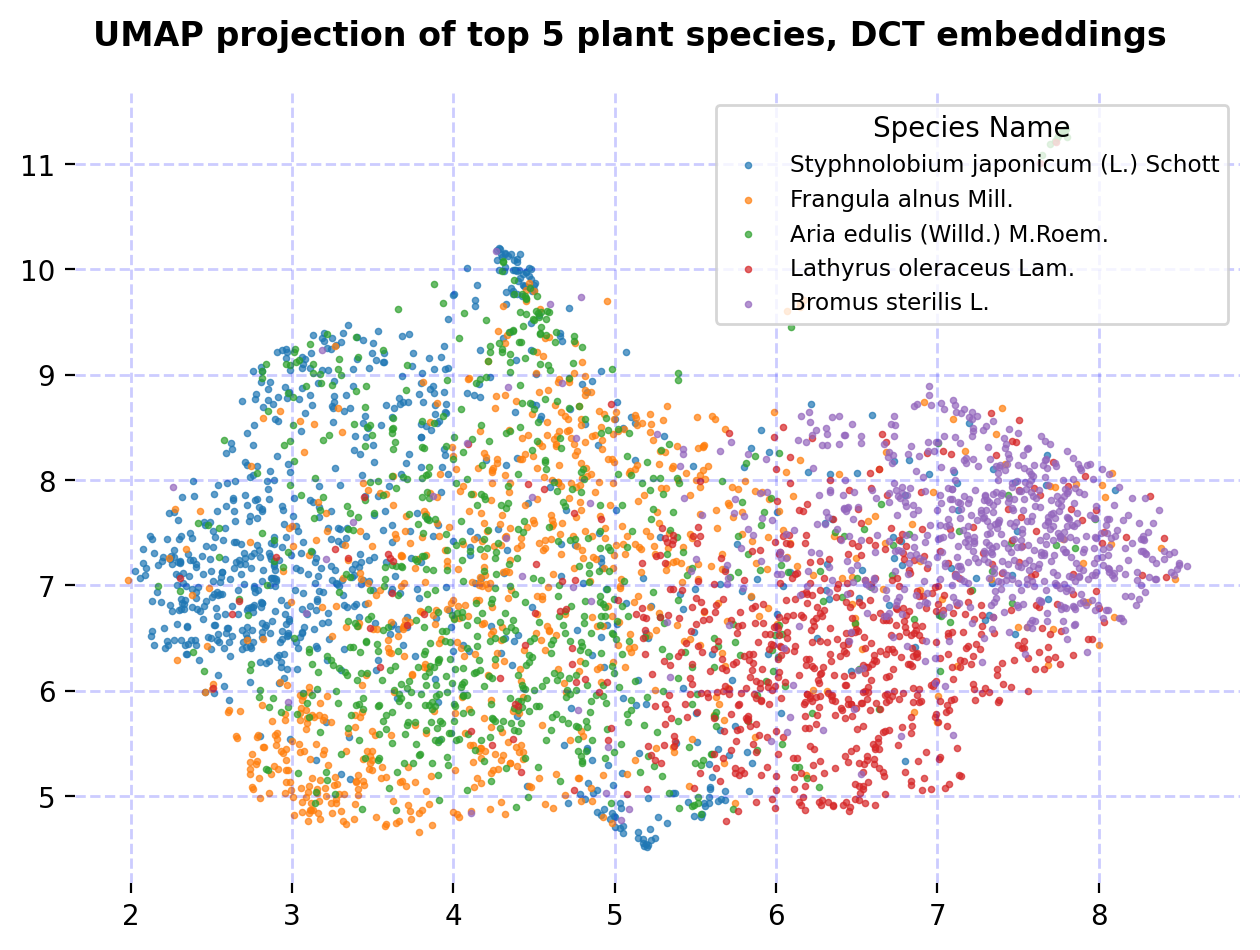

In [9]:
plot_cluster(dct_pandas_df, dct_embedding, algorithm_name="UMAP", emb_name="DCT")

### PaCMAP plot

In [10]:
import pacmap


def get_pacmap_embedding(embedding):
    # PaCMAP
    pacmap_embedding = pacmap.PaCMAP(
        n_components=2, n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0
    )

    # fit the data
    pacmap_transformed = pacmap_embedding.fit_transform(embedding, init="pca")
    return pacmap_transformed

In [11]:
dct_pacmap_transformed = get_pacmap_embedding(embedding=dct_embedding)

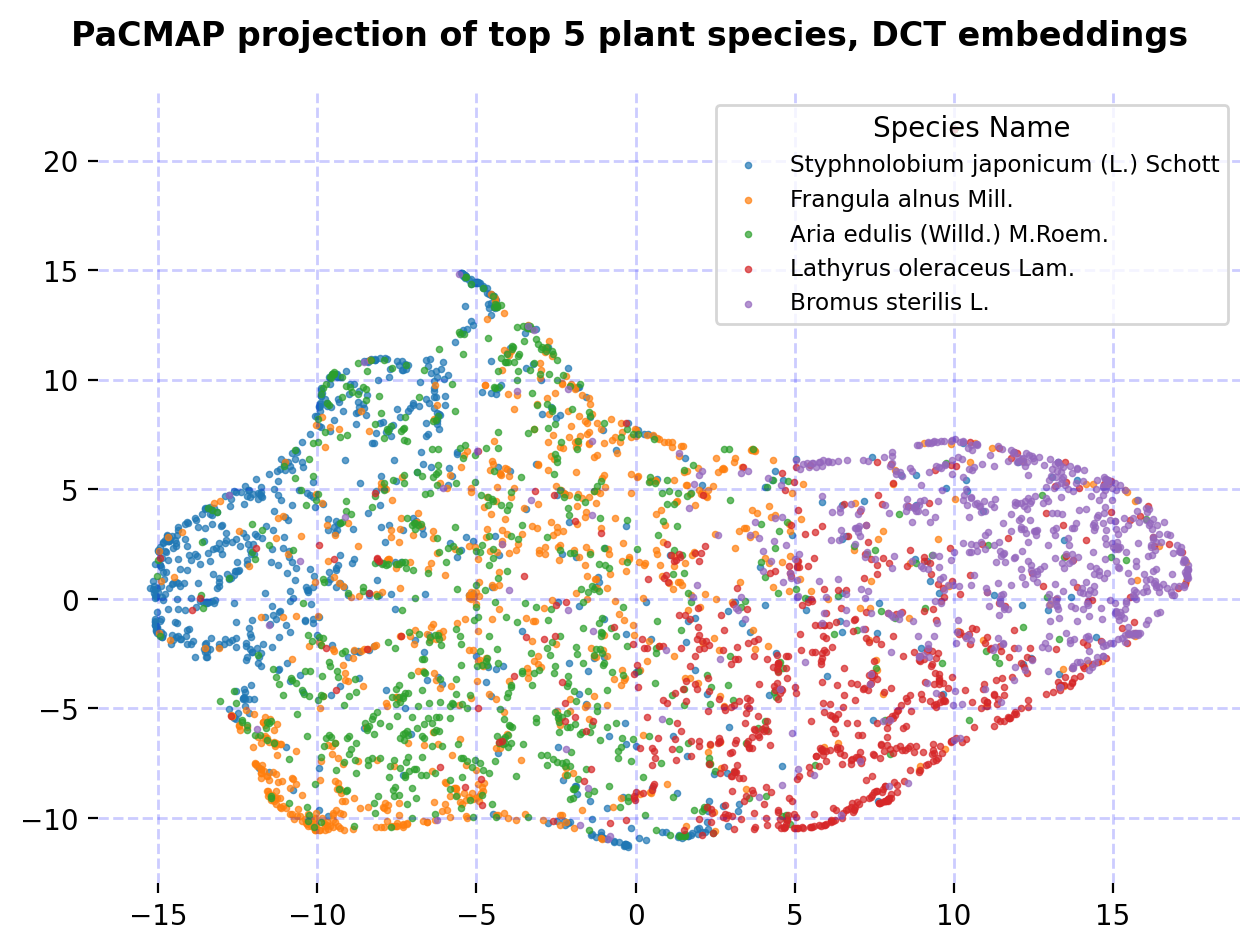

In [12]:
plot_cluster(
    dct_pandas_df, dct_pacmap_transformed, algorithm_name="PaCMAP", emb_name="DCT"
)

# CLS vanilla DINOv2 embeddings

In [13]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data"
cls_emb_path = "process/training_cropped_resized_v2/dino_cls_token/data"
train_path = "parquet_files/PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the embedding files
cls_gcs_path = f"{gcs_path}/{cls_emb_path}"
train_gcs_path = f"{gcs_path}/{train_path}"

# Read the Parquet file into a DataFrame
cls_df = spark.read.parquet(cls_gcs_path)
train_df = spark.read.parquet(train_gcs_path)

# Show the data
cls_df.show(n=5, truncate=50)
train_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+
|                                  image_name|species_id|                                     cls_embedding|
+--------------------------------------------+----------+--------------------------------------------------+
|5ddad155a99ff9b22355b940c100ee588fd73587.jpg|   1390691|[1.2776474, 1.4595255, 1.7950346, 2.156743, 2.8...|
|ea74d65858ceb7d55981560684234b826a7645e2.jpg|   1360260|[-1.9118708, 3.0542357, -3.143496, 1.4037858, 0...|
|86eb8b2e1a7b6a6d4bdd7b49a1e4bd090b867cf5.jpg|   1390699|[0.57074785, 1.7904518, -1.0096772, 1.4558841, ...|
|4dd8c6a10041b1c028823d667316679da4c457fd.jpg|   1396486|[0.85863805, -2.9571414, 1.3469055, -0.8254508,...|
|1d5d139f575031bd13940c1ef10bf4e73dac6d41.jpg|   1356608|[-0.4914153, -1.3314899, 0.33835393, -0.6760831...|
+--------------------------------------------+----------+--------------------------------------------------+
only showing top 5 

+--------------------------------------------+--------------------------------------------------+------+----------+----------+----------------------------------------------+-------+-------------------------------------+--------+-------------+-------------+---------------+--------------------------------------+----------+-------------+--------+-----------+--------------------------------------------------+--------------------------------------------------+---------+--------------------------------------------------+--------------------------------------------------+
|                                  image_name|                                              path| organ|species_id|    obs_id|                                       license|partner|                               author|altitude|     latitude|    longitude|gbif_species_id|                               species|     genus|       family| dataset|  publisher|                                        references|                    

In [14]:
# Get dataframe
cls_sub_df = prepare_emb_df(
    df=cls_df, train_df=train_df, col_name="cls_embedding", num_top_species=5
)

Top 5 species ids: [1369068, 1360257, 1737559, 1741625, 1414366]


In [15]:
# get pandas_df, embeddings
cls_pandas_df, cls_embedding, cls_scaled_emb = get_pandas_embeddings(
    df=cls_sub_df, col_name="cls_embedding"
)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


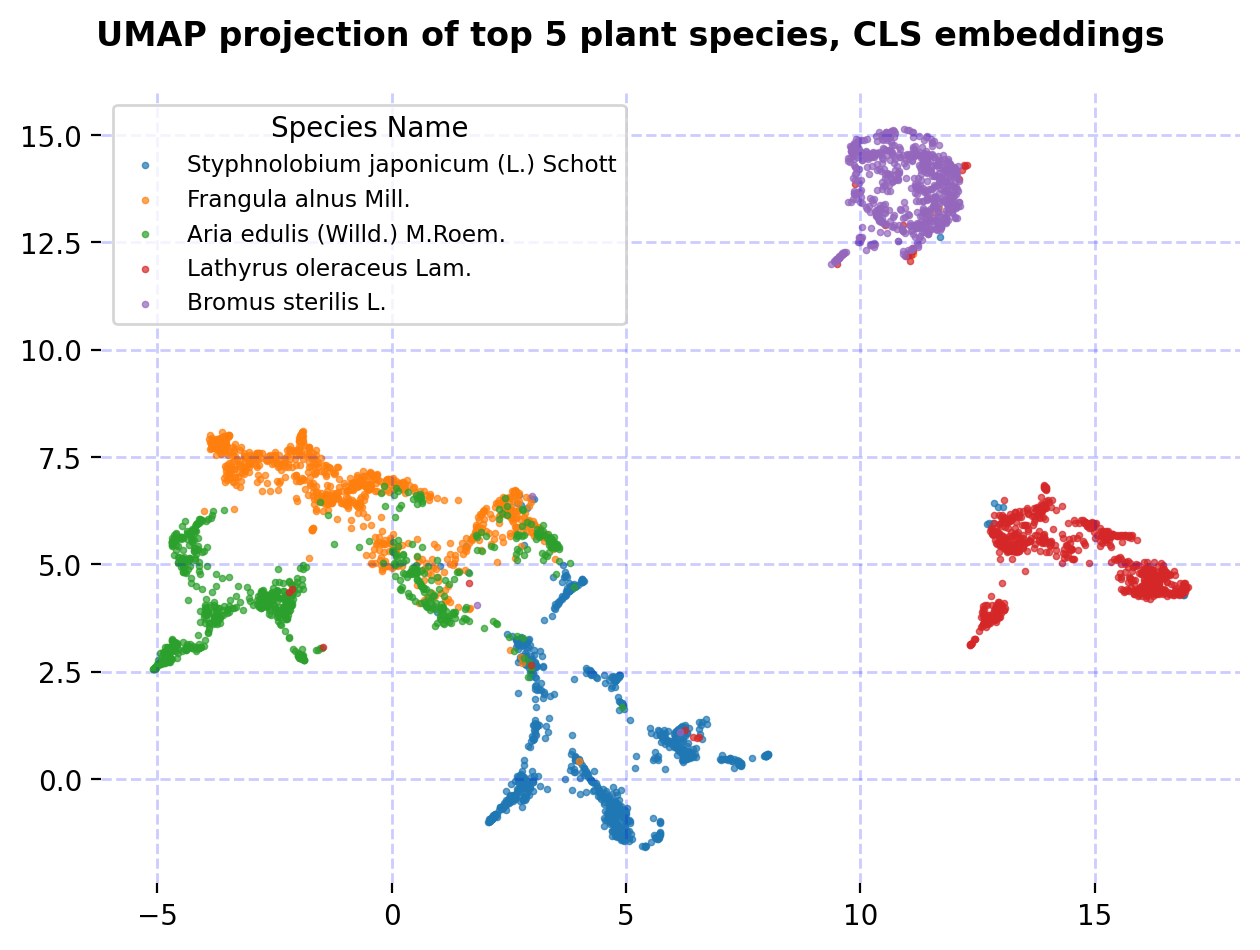

In [16]:
# plot embeddings
plot_cluster(cls_pandas_df, cls_embedding, algorithm_name="UMAP", emb_name="CLS")

### PaCMAP projection

In [17]:
cls_pacmap_transformed = get_pacmap_embedding(cls_embedding)

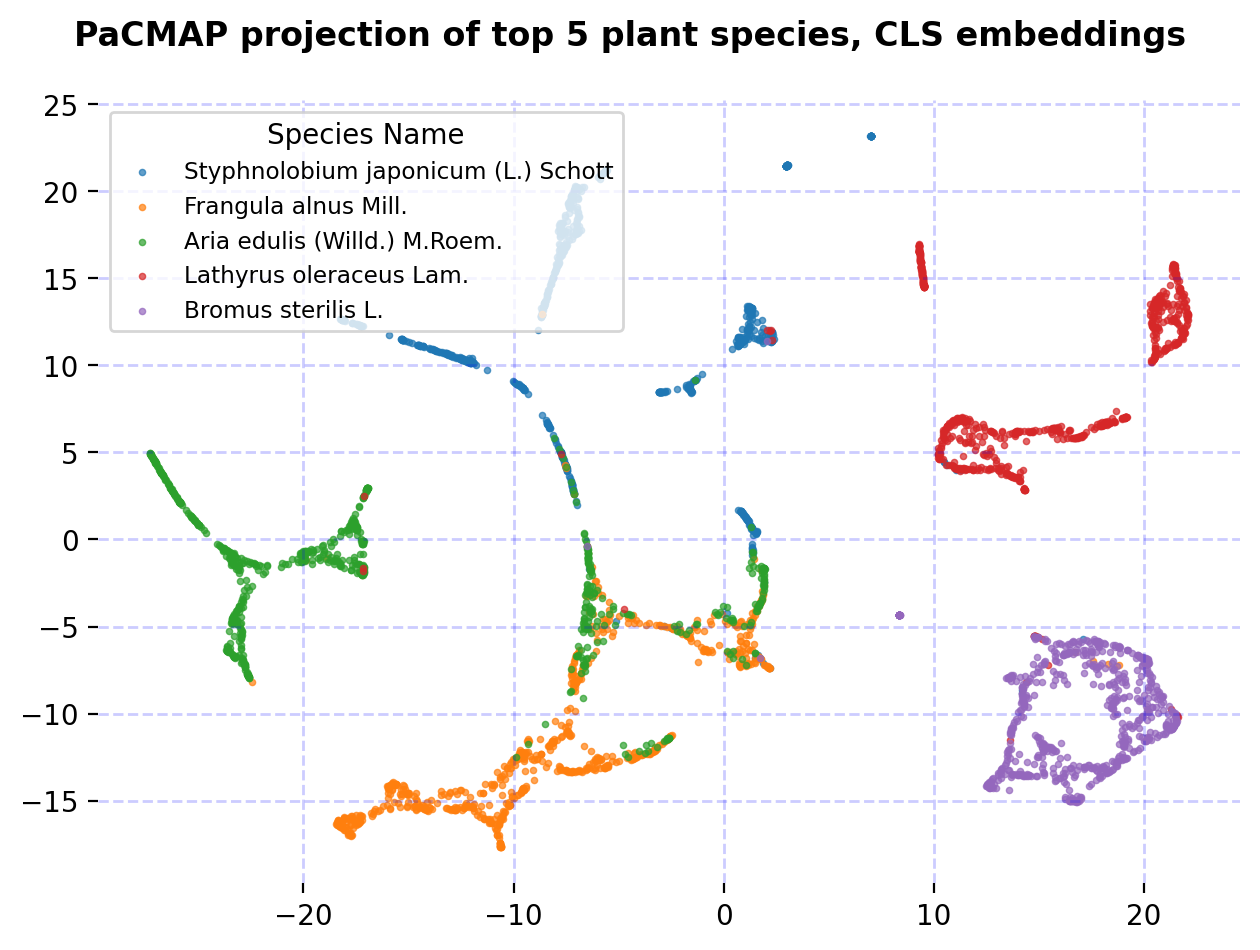

In [18]:
plot_cluster(
    cls_pandas_df, cls_pacmap_transformed, algorithm_name="PaCMAP", emb_name="CLS"
)

# Pretrained DinoV2 embeddings

In [19]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data"
pre_emb_path = "process/training_cropped_resized_v2/dino_pretrained/data"
train_path = "parquet_files/PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the embedding files
pre_gcs_path = f"{gcs_path}/{pre_emb_path}"
train_gcs_path = f"{gcs_path}/{train_path}"

# Read the Parquet file into a DataFrame
pre_df = spark.read.parquet(pre_gcs_path)
train_df = spark.read.parquet(train_gcs_path)

# Show the data
pre_df.show(n=5, truncate=50)
train_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+---------+
|                                  image_name|species_id|                                     cls_embedding|sample_id|
+--------------------------------------------+----------+--------------------------------------------------+---------+
|268ab698373de426d1d59e5f22559ed4e1f11402.jpg|   1390038|[0.23494226, -1.1221137, 0.37612283, 0.17360401...|        1|
|8188c0fb66194bcc1ba6ff60d3f100a360a85614.jpg|   1391312|[1.4406303, 0.47528479, -1.2594234, 0.11041809,...|        1|
|0b77185b1ef8c0c7e6fa5ccee9b95927c7eef2f4.jpg|   1360216|[0.86752903, 1.0569756, 0.720231, -1.7176031, 1...|        1|
|4ce8f5384ed7cd2f677b31b9541622feb52172b6.jpg|   1362653|[0.77440864, 0.7377567, -1.1848863, 0.104509786...|        1|
|7726b10017e8996c8f8eb6bf0c095e4321686fa9.jpg|   1395664|[1.2705524, 0.2547686, -0.36704683, 0.9425047, ...|        1|
+--------------------------------------------+--

+--------------------------------------------+--------------------------------------------------+------+----------+----------+----------------------------------------------+-------+-------------------------------------+--------+-------------+-------------+---------------+--------------------------------------+----------+-------------+--------+-----------+--------------------------------------------------+--------------------------------------------------+---------+--------------------------------------------------+--------------------------------------------------+
|                                  image_name|                                              path| organ|species_id|    obs_id|                                       license|partner|                               author|altitude|     latitude|    longitude|gbif_species_id|                               species|     genus|       family| dataset|  publisher|                                        references|                    

In [20]:
# Get dataframe
pretrained_sub_df = prepare_emb_df(
    df=pre_df, train_df=train_df, col_name="cls_embedding", num_top_species=5
)

Top 5 species ids: [1369068, 1360257, 1737559, 1741625, 1414366]


In [21]:
# get pandas_df, embeddings
pre_pandas_df, pre_embedding, pre_scaled_emb = get_pandas_embeddings(
    df=pretrained_sub_df, col_name="cls_embedding"
)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


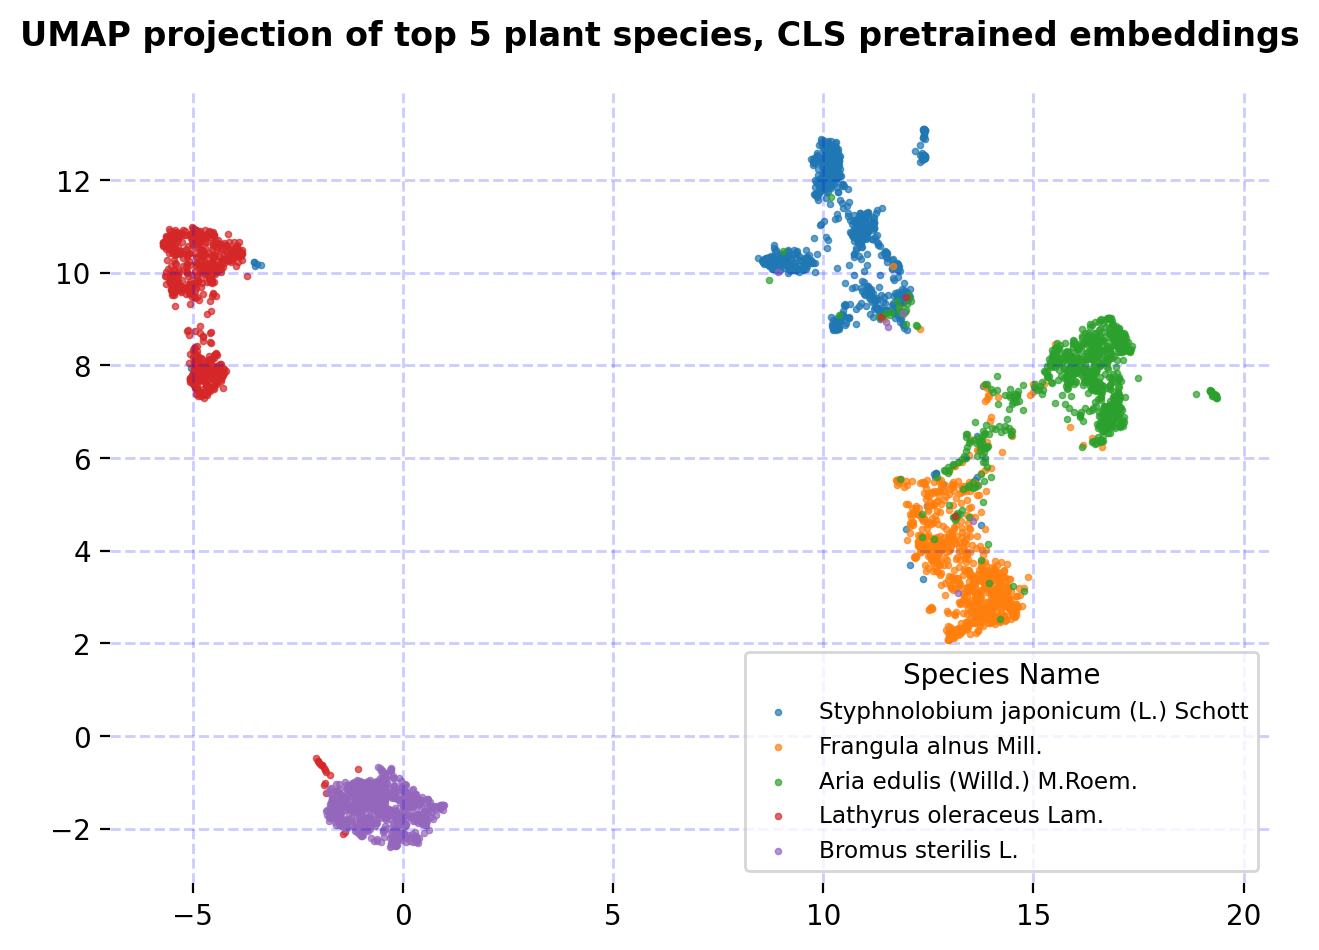

In [22]:
# plot embeddings
plot_cluster(
    pre_pandas_df, pre_embedding, algorithm_name="UMAP", emb_name="CLS pretrained"
)

### PaCMAP projection

In [23]:
pre_pacmap_transformed = get_pacmap_embedding(pre_embedding)

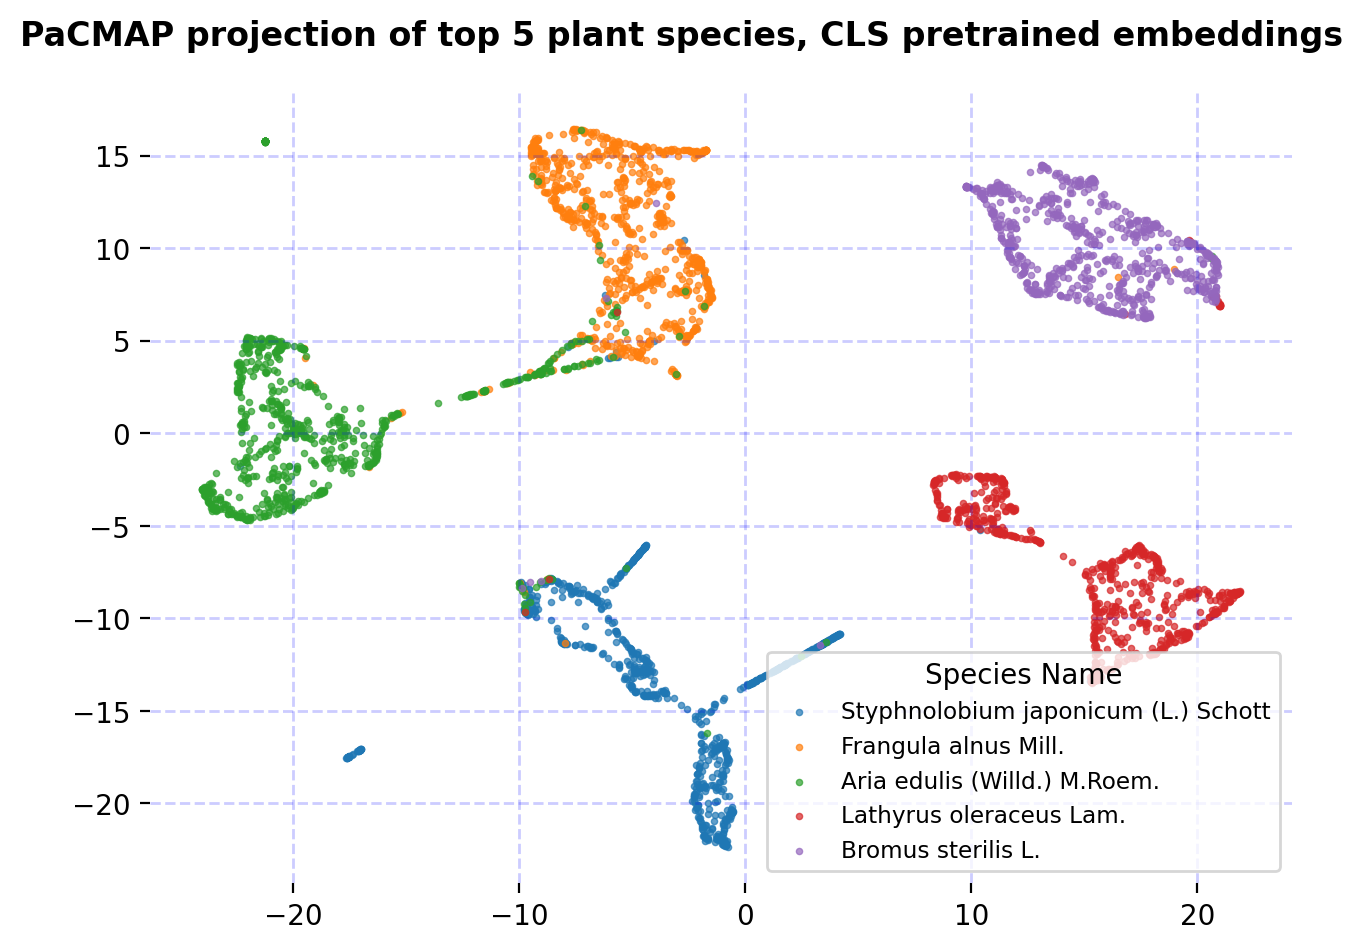

In [24]:
plot_cluster(
    pre_pandas_df,
    pre_pacmap_transformed,
    algorithm_name="PaCMAP",
    emb_name="CLS pretrained",
)